# 设置基本配置

In [ ]:
import qlib
import pandas as pd
from qlib.constant import REG_CN
from qlib.data import D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
# 这个代码仓库不包括qlib_data，需要自己下载，要下载到对应目录，../qlib_data/qlib_bin的目录有三个文件夹，分别是：
# calendars, features, instruments，
# https://github.com/chenditc/investment_data/releases/latest/download/qlib_bin.tar.gz
qlib.init(provider_uri='../qlib_data/qlib_bin', region=REG_CN)

[9128:MainThread](2025-06-09 13:48:28,149) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[9128:MainThread](2025-06-09 13:48:29,288) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[9128:MainThread](2025-06-09 13:48:29,303) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': WindowsPath('E:/MYRL/qlib quant invest/qlib_data/qlib_bin')}


# 准备数据

In [2]:
instruments = ['SH600000', 'SH600009', 'SH600010', 'SH600011', 'SH600015', 'SH600016', 'SH600018', 'SH600019', 'SH600023', 'SH600025']
fields = ['$close', '$volume', 'Ref($close, 1)', 'Mean($close, 3)', '$high-$low' , '$close/Ref($close, 1)-1', 'Std($close, 3)']
data = D.features(instruments, fields, start_time='2022-01-01', end_time='2024-01-01', freq='day')
# data = D.features(D.instruments(market='csi300'), fields, start_time='2020-01-01', end_time='2024-01-01', freq='day')
data = data.swaplevel(0,1).sort_index()
prices = data['$close']
features = data.drop(columns=['$close'])
min_max_scaler = StandardScaler()
min_max_scaler = min_max_scaler.fit(features)
original_index = features.index
original_columns = features.columns
values = features.values
scaled_values = min_max_scaler.fit_transform(values)
features = pd.DataFrame(scaled_values, index=original_index, columns=original_columns)


In [3]:
features.fillna(method='ffill', inplace=True)
features.fillna(method='bfill', inplace=True)
prices.fillna(method='ffill', inplace=True)
prices.fillna(method='bfill', inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9128\2530449986.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9128\2530449986.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='bfill', inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9128\2530449986.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices.fillna(method='ffill', inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9128\2530449986.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices.fillna(method='

# 设置交易环境和智能体

In [4]:
import torch.nn as nn
import numpy as np
import torch
from gym import spaces
import gym
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3

In [136]:
class TradingEnv(gym.Env):
    def __init__(self, **config):
        super(TradingEnv, self).__init__()
        self.config = config['config']
        self.data = config['data']
        
        # Ensure 'features' is a DataFrame with MultiIndex (Date, Stock_ID)
        # Ensure 'prices' is a DataFrame with MultiIndex (Date, Stock_ID)
        # Assuming self.data["stock_ids"] is a list of stock IDs for correct indexing
        
        self.feature_dim = self.data["features"].shape[1] * self.config["window_size"] * len(self.data["stock_ids"])
        self.date_index = self.data["features"].index.get_level_values(0).unique().tolist()
        
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(len(self.data["stock_ids"]),), dtype=np.float32
        )

        # Observation space now also includes normalized positions and capital
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.feature_dim + len(self.data["stock_ids"]) + 1,),
            dtype=np.float32
        )

        self.reset()

    def reset(self):
        """Reset the environment state to its initial conditions."""
        # Start the trading window after enough data for the initial observation
        self.current_step = self.config['window_size'] 
        self.capital = float(self.config["initial_capital"]) # Ensure capital is float
        # Start with no positions to simplify initial state and avoid "free" assets
        self.positions = np.zeros(len(self.data["stock_ids"]), dtype=np.float32) 
        
        self.total_assets_history = [self.capital]
        self.actions_history = []
        return self._get_observation()

    def _get_observation(self):
        """Get the current observation from the environment."""
        # Extract features for the current window. Make sure the data indexing is correct.
        # .loc[dates] should return a DataFrame that can be flattened
        features_df = self.data['features'].loc[self.date_index[self.current_step-self.config['window_size']:self.current_step]]
        features = features_df.values.reshape(-1) # Flatten for the observation space
        
        # Normalize positions (e.g., by initial capital or current portfolio value)
        # For simplicity, let's normalize by current assets if not zero, or initial capital
        current_portfolio_value = np.sum(self.positions * self.data['prices'].loc[self.date_index[self.current_step-1]].values) # Use previous day's price for observation if possible
        # Or, just use positions directly if normalization by scale is handled by the model.
        
        # A simple normalization for positions could be self.positions / self.total_assets
        # However, for simplicity, let's keep it unnormalized in the observation for now,
        # assuming the RL algorithm or a preprocessing layer will handle scaling.
        
        observation = np.concatenate([
            features,
            self.positions, # Agent needs to know current holdings
            [self.capital / self.config["initial_capital"]] # Normalized capital
        ])
        return observation

    def step(self, action):
        self.actions_history.append(action)
        
        # Get current prices for all stocks. Ensure prices are aligned with stock_ids order.
        current_prices = self.data['prices'].loc[self.date_index[self.current_step]].values 
        
        # Calculate assets at the beginning of the step (before any trades)
        current_portfolio_value = np.sum(self.positions * current_prices)
        current_total_assets = self.capital + current_portfolio_value
        
        # --- Transaction Logic ---
        # The agent's action is a continuous value between -1 and 1.
        # Let's interpret positive action as buying intent and negative as selling intent.
        # We need a scaling factor for how much 'unit' an action of 1.0 corresponds to.
        # Your original 1000.0 is a good starting point for a "max trade size".
        trade_units_per_action_scale = 1000.0 
        
        # Calculate desired cash flow for each stock
        # Positive values mean buying, negative mean selling.
        desired_cash_flow = action * trade_units_per_action_scale * current_prices 
        
        # Initialize actual changes
        actual_capital_change = 0.0
        actual_positions_change = np.zeros_like(self.positions, dtype=np.float32)
        transaction_costs_incurred = 0.0

        # --- Process Sells First ---
        # It's usually safer to process sells first to free up capital before buying,
        # or treat buys/sells as simultaneous if capital isn't an issue.
        # For robustness, let's process sells for all stocks first, then buys.
        
        # Identify stocks to sell (actions < 0)
        sell_indices = np.where(action < 0)[0]
        
        # Sort sells by magnitude (e.g., sell most aggressively first, or least)
        # For simplicity, let's process in original index order for now.
        
        for i in sell_indices:
            desired_sell_shares = -desired_cash_flow[i] / current_prices[i] # Convert desired cash_flow to shares
            
            # You cannot sell more shares than you currently hold
            actual_sell_shares = min(desired_sell_shares, self.positions[i])
            
            # Calculate cash received and transaction cost for selling
            cash_received = actual_sell_shares * current_prices[i]
            sell_cost = cash_received * self.config['transaction_cost']
            
            self.capital += (cash_received - sell_cost)
            self.positions[i] -= actual_sell_shares
            transaction_costs_incurred += sell_cost
            actual_positions_change[i] -= actual_sell_shares # Track for info
            actual_capital_change += (cash_received - sell_cost)

        # --- Process Buys Next ---
        buy_indices = np.where(action > 0)[0]
        
        for i in buy_indices:
            desired_buy_shares = desired_cash_flow[i] / current_prices[i] # Convert desired cash_flow to shares
            
            # Calculate cost for buying desired shares
            potential_buy_cost = desired_buy_shares * current_prices[i] * (1 + self.config['transaction_cost'])
            
            # You cannot buy more than your available capital allows
            if self.capital >= potential_buy_cost:
                actual_buy_shares = desired_buy_shares
            else:
                # Buy as many shares as possible with remaining capital
                # Capital / (price * (1 + transaction_cost))
                actual_buy_shares = self.capital / (current_prices[i] * (1 + self.config['transaction_cost']))
                if actual_buy_shares < 0: actual_buy_shares = 0 # Safety check for division by zero or negative price
                
            buy_cost = actual_buy_shares * current_prices[i] * (1 + self.config['transaction_cost'])

            self.capital -= buy_cost
            self.positions[i] += actual_buy_shares
            transaction_costs_incurred += (buy_cost - (actual_buy_shares * current_prices[i])) # Only the cost part
            actual_positions_change[i] += actual_buy_shares # Track for info
            actual_capital_change -= buy_cost
            
        # --- End Transaction Logic ---

        # Move to the next time step
        self.current_step += 1
        
        # Check if environment is done (reached the end of available data)
        done = self.current_step >= len(self.date_index) - 1

        # Get prices for the end of the step (next day's prices for reward calculation)
        # If it's the last step, use the current day's prices for final calculation
        if not done:
            next_prices = self.data['prices'].loc[self.date_index[self.current_step]].values
        else:
            next_prices = current_prices # Use current prices if at the very end

        # Calculate new total assets after positions have changed and prices have moved
        new_portfolio_value = np.sum(self.positions * next_prices)
        new_total_assets = self.capital + new_portfolio_value
        
        # Reward calculation: Percentage change in total assets
        # Avoid division by zero if starting assets were zero (unlikely but good practice)
        if current_total_assets > 0:
            reward = (new_total_assets - current_total_assets) / current_total_assets
        else:
            reward = 0.0 # No reward if no assets to start with

        # Reward shaping: Consider if cubing is appropriate.
        # Cubing can make the reward sparse and hard to learn from for small gains/losses.
        # Alternative: reward = np.clip(reward, -0.1, 0.1) # Simpler clipping without cubing
        reward = reward * 1.05**self.current_step # Cubing the reward

        self.total_assets_history.append(new_total_assets)
        obs = self._get_observation() # Get observation for the next state

        # Information dictionary for debugging and logging
        info = {
            "assets": new_total_assets, 
            "positions": self.positions.copy(), # Return a copy to prevent external modification
            "capital": self.capital, 
            "current_step": self.current_step,
            "transaction_costs": transaction_costs_incurred,
            "reward_raw": (new_total_assets - current_total_assets) / current_total_assets if current_total_assets > 0 else 0.0
        }
        
        return obs, reward, done, info

In [137]:
train_env_config = {
    "data":{
        "features": features,
        "prices": prices,
        "stock_ids": prices.index.get_level_values(1).unique().tolist(),
    },
    "config": {
        "initial_capital": 100000,
        "transaction_cost": 0.003,
        "window_size": 20,
        "allow_short": True,
    },
    
}
train_env = TradingEnv(**train_env_config)

# 训练智能体

In [118]:
agent = PPO('MlpPolicy', train_env,device="cpu",verbose=True)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


d:\ProgramData\anaconda3\envs\nlpgettingstarted\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [138]:
agent.learn(total_timesteps=10000000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 463      |
|    ep_rew_mean     | 0.144    |
| time/              |          |
|    fps             | 626      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 463         |
|    ep_rew_mean          | 0.142       |
| time/                   |             |
|    fps                  | 553         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009547549 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10         |
|    explained_variance   | 0.125       |
|    learning_rate        | 0.

KeyboardInterrupt: 

# 在训练数据上测试

In [139]:
train_env.reset()
obs = train_env.reset()
done = False
total_reward = 1
rewards_history = []
assets_history = []
actions_history = []
positions_history = []
capital_history = []
while not done:
    action, _ = agent.predict(obs, deterministic=True)
    actions_history.append(action)
    obs, reward, done, info = train_env.step(action)
    total_reward *= (reward+1)
    rewards_history.append(total_reward)
    assets_history.append(info['assets'])
    positions_history.append(info['positions'].copy())
    capital_history.append(info['capital'])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9128\2063179482.py:14: RuntimeWarning: overflow encountered in scalar multiply
  total_reward *= (reward+1)


In [140]:
capital_history[-1]

np.float32(-0.00024414062)

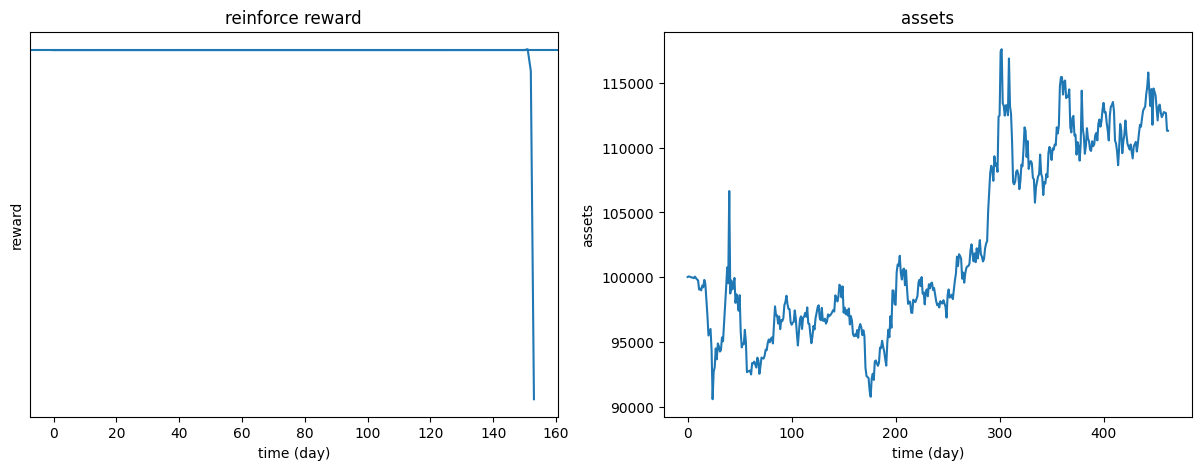

In [141]:

results = pd.DataFrame({
    "reward": rewards_history,
    "assets": assets_history,
})
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('reinforce reward')
sns.lineplot(results,x = results.index,y = 'reward')
plt.axhline(y=0, linestyle='-')
plt.yticks([])
plt.xlabel('time (day)')
plt.subplot(1, 2, 2)
plt.title('assets')
sns.lineplot(results,x = results.index,y = 'assets')
plt.xlabel('time (day)')
plt.show()

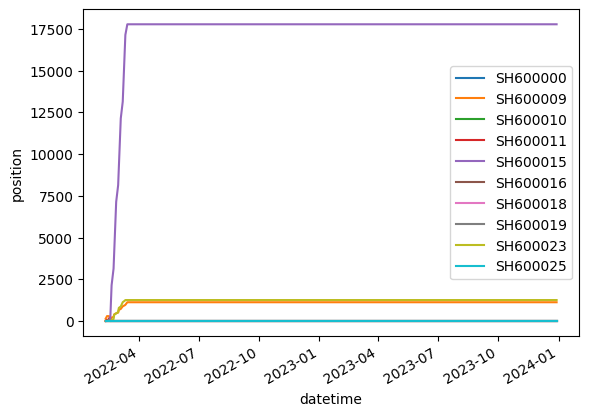

In [142]:
pd.DataFrame(np.stack(positions_history),
                index=prices[prices.index.get_level_values('datetime') >= '2022-02-09'].index.get_level_values('datetime').unique(),
                columns=prices.index.get_level_values(1).unique().tolist()).plot()
plt.ylabel('position')
plt.show()

In [143]:
agent.save("./models/ppo_model.pkl")